<a target="_blank" href="https://colab.research.google.com/github/lamm-mit/MechAgents/blob/main/0_colab_notebook_for_TwoAgentTeam_Elasticity/0_TwoAgen_MultiStep_LElasticity.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# A Two-agent team solves linear elasticity problems of various flavors in multiple runs of conversations
Reference:
Ni, Bo, and Markus J. Buehler. "MechAgents: Large language model multi-agent collaborations can solve mechanics problems, generate new data, and integrate knowledge." Extreme Mechanics Letters (2024)

# 0. Prepare the packages

In [1]:
#@title #### prepare fenics for colab

try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2023-11-05 22:31:24--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-11-05 22:31:24 (41.2 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/af0ba58/releases/pybind11-install.s

In [2]:
#@title #### prepare autogen

try:
    import chromadb
except ImportError:
    !pip install chromadb==0.4.15
    import chromadb

try:
    import tiktoken
except ImportError:
    !pip install tiktoken==0.5.1
    import tiktoken

try:
    import pypdf
except ImportError:
    !pip install pypdf==3.17.0
    import pypdf

# add autogen
#
try:
    import autogen
except ImportError:
    !pip install pyautogen==0.1.14
    import autogen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.8/479.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.7/593.7 kB 5

# 1. Working part

## 1.1 Set the API endpoint

In [3]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    file_location=".",
    filter_dict={
        "model": ["gpt-3.5-turbo", "gpt-35-turbo", "gpt-35-turbo-0613", "gpt-4", "gpt4", "gpt-4-32k"],
    },
)

print("LLM models: ", [config_list[i]["model"] for i in range(len(config_list))])

LLM models:  []


In [4]:
# here, we set it locally
config_list_gpt = [
    {
        "model": "gpt-4",
        "api_key": "Your openAI API key"
    }
]


##1.2 Construct agents

In [5]:
# gpt4_config = {
#     "seed": 42,  # change the seed for different trials
#     "temperature": 0,
#     "config_list": config_list_gpt,
#     "request_timeout": 240,
# }

gpt4_config = {
    "seed": 42,  # change the seed for different trials
    "temperature": 0,
    "config_list": config_list_gpt,
    "request_timeout": 600,
    "retry_wait_time": 120,
}

In [9]:
# create a UserProxyAgent instance named "user_proxy"
# 1. run code written by assistantAgent
# 2. provide feedback if needed, but keep quite during one round
#
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "Mechanics",
        "use_docker": False,  # set to True or image name like "python:3" to use docker
    },
)


# create an AssistantAgent named "assistant"
# assistant = autogen.AssistantAgent(
#     name="assistant",
#     llm_config=gpt4_config,  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
#     system_message='''Assistant. You make plan, formulate the problem, write code using FENICS and review the result.'''
# )

assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config=gpt4_config,  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)


# # the assistant receives a message from the user_proxy, which contains the task description
# user_proxy.initiate_chat(
#     assistant,
#     message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
# )

In [10]:
# the assistant receives a message from the user_proxy, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""A 1m-by-1m elastic plate has Young's modulus of 1GPa and Poisson ration of 0.3.
    It has zero displacement on the left edge and 0.1m displacement along x direction on the right edge.
    Solve for the displacement using FENICS and store the displacement result in a PNG file.""",
)

user_proxy (to assistant):

A 1m-by-1m elastic plate has Young's modulus of 1GPa and Poisson ration of 0.3.
    It has zero displacement on the left edge and 0.1m displacement along x direction on the right edge.
    Solve for the displacement using FENICS and store the displacement result in a PNG file.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To solve this problem, we will use the FEniCS library in Python. FEniCS is a popular open-source (LGPLv3) computing platform for solving partial differential equations (PDEs). It allows users to quickly translate scientific models into efficient finite element code.

Here is the Python code to solve the problem:

```python
# filename: displacement.py

from fenics import *
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMesh(10, 10)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
def left_boundary(x, on_boundary):
    

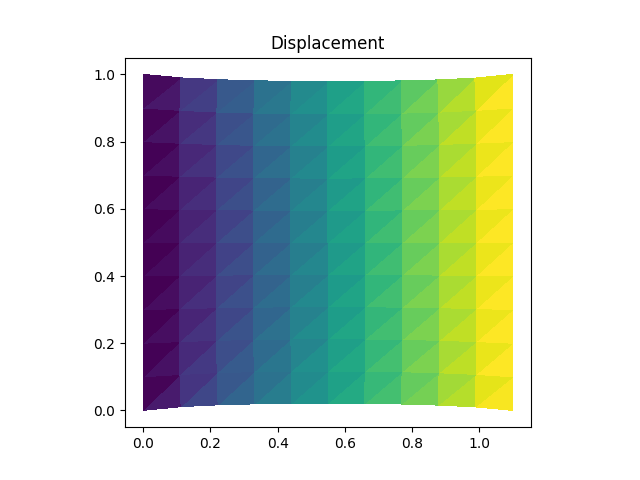

In [11]:
from IPython.display import Image
Image('./Mechanics/displacement.png')

In [12]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Let's change the boundary condition on the right edge to a shear case,
    i.e., the displacement along y direction is 0.1m on the right edge.
    Please refine the mesh to 50-by-50 elements, solve the problem again and save result into another png file.""",
)

user_proxy (to assistant):

Let's change the boundary condition on the right edge to a shear case,
    i.e., the displacement along y direction is 0.1m on the right edge.
    Please refine the mesh to 50-by-50 elements, solve the problem again and save result into another png file.

--------------------------------------------------------------------------------
assistant (to user_proxy):

Sure, we can modify the boundary condition and refine the mesh as per your request. Here is the updated Python code:

```python
# filename: displacement_shear.py

from fenics import *
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMesh(50, 50)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0)

def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], 1)

bc_left = DirichletBC(V, Constant((0, 0)), left_boundary)
bc_right = DirichletBC(V, Constant((0, 0

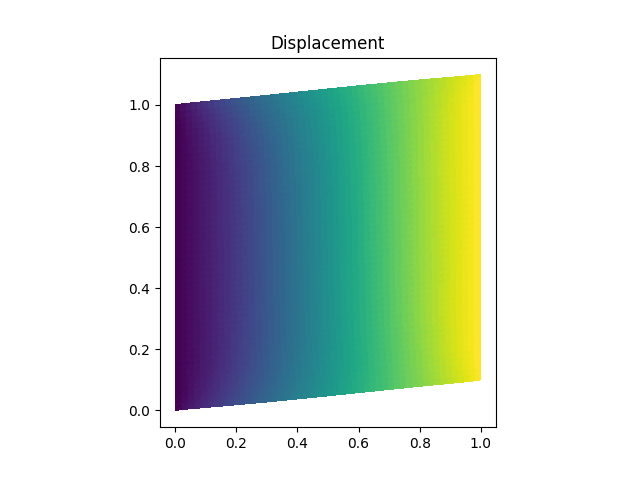

In [13]:
Image('./Mechanics/displacement_shear.png')

In [14]:
user_proxy.send(
    recipient=assistant,
    message="""Let's add a circular hole of radius 0.2m in the middle of the original square domain.
    Please solve the share problem and save result into another png file.""",
)

user_proxy (to assistant):

Let's add a circular hole of radius 0.2m in the middle of the original square domain.
    Please solve the share problem and save result into another png file.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To add a circular hole in the middle of the square domain, we need to define a new mesh that includes this hole. FEniCS does not directly support mesh generation with holes, so we will use the mshr library, which is a meshing tool for FEniCS.

Here is the updated Python code:

```python
# filename: displacement_shear_hole.py

from fenics import *
from mshr import *
import matplotlib.pyplot as plt

# Define domain and create mesh
domain = Rectangle(Point(0, 0), Point(1, 1)) - Circle(Point(0.5, 0.5), 0.2)
mesh = generate_mesh(domain, 50)

V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0)

def right_bound

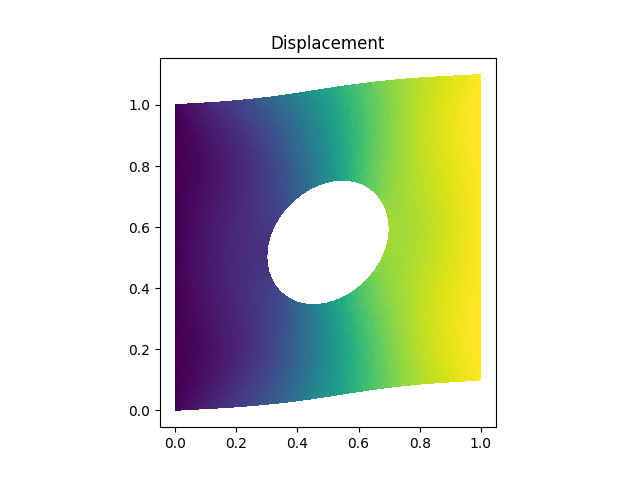

In [15]:
Image('./Mechanics/displacement_shear_hole.png')

In [16]:
# check understanding the geometery
#
user_proxy.send(
    recipient=assistant,
    message="""Let's also calculate the stress component sigma_xy and save it into another png file.""",
)

user_proxy (to assistant):

Let's also calculate the stress component sigma_xy and save it into another png file.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To calculate the stress component sigma_xy, we can use the stress function defined in the script. The stress function returns a symmetric 2x2 tensor, and the off-diagonal elements represent the shear stress sigma_xy.

Here is the updated Python code:

```python
# filename: stress_shear_hole.py

from fenics import *
from mshr import *
import matplotlib.pyplot as plt

# Define domain and create mesh
domain = Rectangle(Point(0, 0), Point(1, 1)) - Circle(Point(0.5, 0.5), 0.2)
mesh = generate_mesh(domain, 50)

V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0)

def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], 1)

bc_left = DirichletBC(V, Constant((0, 0)), 

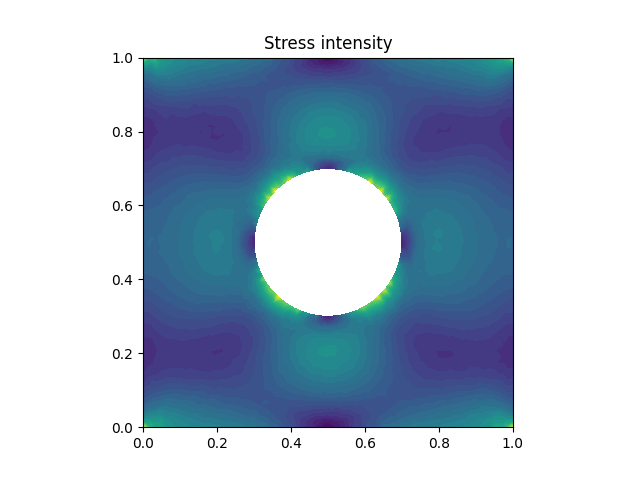

In [17]:
Image('./Mechanics/stress_shear_hole.png')

In [18]:
user_proxy.send(
    recipient=assistant,
    message="""You plotted von Mises stress, not stress component sigma_xy. Please correct """,
)

user_proxy (to assistant):

You plotted von Mises stress, not stress component sigma_xy. Please correct 

--------------------------------------------------------------------------------
assistant (to user_proxy):

I apologize for the misunderstanding. You're right, the von Mises stress is a scalar quantity derived from the stress tensor, not the shear stress component sigma_xy. 

To compute the shear stress component sigma_xy, we can extract it from the stress tensor. Here is the corrected script:

```python
# filename: stress_shear_hole.py

from fenics import *
from mshr import *
import matplotlib.pyplot as plt

# Define domain and create mesh
domain = Rectangle(Point(0, 0), Point(1, 1)) - Circle(Point(0.5, 0.5), 0.2)
mesh = generate_mesh(domain, 50)

V = VectorFunctionSpace(mesh, 'P', 1)
W = FunctionSpace(mesh, 'P', 1)  # Scalar function space for stress

# Define boundary condition
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0)

def right_boundary(x, on

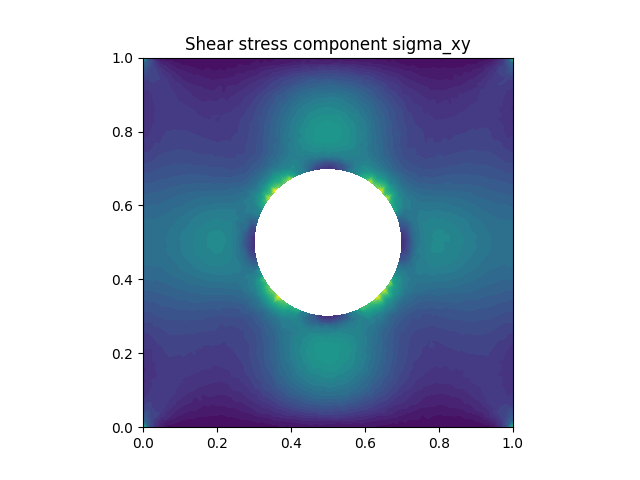

In [19]:
Image('./Mechanics/stress_shear_hole.png')

In [20]:
user_proxy.send(
    recipient=assistant,
    message="""Let's fill in the hole with another material of Young's mudulus 10GPa.
    Please solve the problem and save displacement and stress sigma_xy in png files.""",
)

user_proxy (to assistant):

Let's fill in the hole with another material of Young's mudulus 10GPa. 
    Please solve the problem and save displacement and stress sigma_xy in png files.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To fill the hole with another material, we need to define a new domain for the hole and assign different material properties to it. We can use the `MeshFunction` in FEniCS to mark the cells that belong to the hole.

Here is the updated Python code:

```python
# filename: stress_shear_filled_hole.py

from fenics import *
from mshr import *
import matplotlib.pyplot as plt

# Define domain and create mesh
outer_domain = Rectangle(Point(0, 0), Point(1, 1))
inner_domain = Circle(Point(0.5, 0.5), 0.2)
domain = outer_domain - inner_domain
mesh = generate_mesh(domain, 50)

# Define subdomains
class Outer(SubDomain):
    def inside(self, x, on_boundary):
        return (x[0] - 0.5)**2 + (x[1] - 0.5)**2 >=

InvalidRequestError: ignored

## Keep the files

In [21]:
!ls ./Mechanics

displacement000000.vtu		   displacement_shear_hole.png	stress_shear_hole000000.vtu
displacement.png		   displacement_shear_hole.pvd	stress_shear_hole.png
displacement.pvd		   displacement_shear_hole.py	stress_shear_hole.pvd
displacement.py			   displacement_shear.png	stress_shear_hole.py
displacement_shear000000.vtu	   displacement_shear.pvd
displacement_shear_hole000000.vtu  displacement_shear.py


In [22]:
!zip -r /content/OneChat_Mechanics_file.zip /content/Mechanics

  adding: content/Mechanics/ (stored 0%)
  adding: content/Mechanics/displacement.pvd (deflated 28%)
  adding: content/Mechanics/displacement.png (deflated 18%)
  adding: content/Mechanics/displacement_shear.png (deflated 6%)
  adding: content/Mechanics/displacement_shear_hole.py (deflated 52%)
  adding: content/Mechanics/stress_shear_hole000000.vtu (deflated 60%)
  adding: content/Mechanics/stress_shear_hole.py (deflated 54%)
  adding: content/Mechanics/displacement000000.vtu (deflated 71%)
  adding: content/Mechanics/displacement_shear_hole000000.vtu (deflated 65%)
  adding: content/Mechanics/displacement_shear_hole.png (deflated 3%)
  adding: content/Mechanics/displacement_shear.py (deflated 51%)
  adding: content/Mechanics/displacement.py (deflated 51%)
  adding: content/Mechanics/displacement_shear.pvd (deflated 27%)
  adding: content/Mechanics/displacement_shear000000.vtu (deflated 72%)
  adding: content/Mechanics/stress_shear_hole.png (deflated 4%)
  adding: content/Mechanics/st

In [23]:
from google.colab import files

files.download("/content/OneChat_Mechanics_file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>